In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal, Independent
import numpy as np
import matplotlib.pyplot as plt
import collections

## Data Generation

In [11]:
class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

    Supports vector inputs (x) and vector outputs (y). Kernel is
    mean-squared exponential, using the x-value l2 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes.
    """

    def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.4,
               sigma_scale=1.0,
               testing=False):
        """Creates a regression dataset of functions sampled from a GP.

        Args:
          batch_size: An integer.
          max_num_context: The max number of observations in the context.
          x_size: Integer >= 1 for length of "x values" vector.
          y_size: Integer >= 1 for length of "y values" vector.
          l1_scale: Float; typical scale for kernel distance function.
          sigma_scale: Float; typical scale for variance.
          testing: Boolean that indicates whether we are testing. If so there are
              more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

        Args:
          xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
              the values of the x-axis data.
          l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
              parameter of the Gaussian kernel.
          sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
              of the std.
          sigma_noise: Float, std of the noise that we add for stability.

        Returns:
          The kernel, a float tensor with shape
          `[batch_size, y_size, num_total_points, num_total_points]`.
        """
        num_total_points = xdata.shape[1]

        # Expand and take the difference
        xdata1 = torch.unsqueeze(xdata, 1)  # [B, 1, num_total_points, x_size]
        xdata2 = torch.unsqueeze(xdata, 2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = torch.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

        norm = torch.sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

        # [B, y_size, num_total_points, num_total_points]
        kernel = torch.square(sigma_f)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise**2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2 and 2.

        Returns:
          A `CNPRegressionDescription` namedtuple.
        """
        num_context = torch.randint(size=[], low=3, high=self._max_num_context)

        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.unsqueeze(torch.arange(-2.,2.,1./100), 0).repeat([self._batch_size, 1])
            x_values = torch.unsqueeze(x_values, axis=-1)
        # During training the number of target points and their x-positions are
        # selected at random
        else:
            num_target = torch.randint(size=[], low=2, high=self._max_num_context)
            num_total_points = num_context + num_target
            x_values = torch.Tensor(self._batch_size, num_total_points, self._x_size).uniform_(-2, 2)

        # Set kernel parameters
        l1 = torch.ones([self._batch_size, self._y_size, self._x_size])*self._l1_scale
        sigma_f = torch.ones([self._batch_size, self._y_size]) * self._sigma_scale

        # Pass the x_values through the Gaussian kernel
        # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

        # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel.double()).float()

        # Sample a curve
        # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(cholesky,torch.normal(0.0, 1.0, [self._batch_size, self._y_size, num_total_points, 1]))

        # [batch_size, num_total_points, y_size]
        y_values = torch.squeeze(y_values, 3).permute(0, 2, 1)

        if self._testing:
          # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            #### MAYBE WRONG
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]


        return context_x, context_y, target_x, target_y

## Encoder:

In [12]:
class DeterministicEncoder(nn.Module):
    """The Encoder."""
    
    def __init__(self, layer_sizes):
        super(DeterministicEncoder, self).__init__()
        self.Linears = nn.ModuleList([nn.Linear(s1,s2) for s1,s2 in zip(layer_sizes[:-1],layer_sizes[1:])])
        

    def forward(self, context_x, context_y):
        # Concatenate x and y along the filter axes
        x = torch.cat([context_x, context_y], dim=-1)
        
        batch_size, num_context_points, filter_size = x.shape
        x = x.reshape(batch_size * num_context_points, -1)
        
        # Pass through MLP
        for lay in self.Linears[:-1]:
            x = F.relu(lay(x))
        # Last layer without a ReLu
        x = self.Linears[-1](x)
        
        x = x.reshape(batch_size, num_context_points, x.shape[-1])
        return x.mean(axis=1)
    

## Decoder

In [13]:
class DeterministicDecoder(nn.Module):

    def __init__(self, layer_sizes):
        super(DeterministicDecoder, self).__init__()
        self.Linears = nn.ModuleList([nn.Linear(s1,s2) for s1,s2 in zip(layer_sizes[:-1],layer_sizes[1:])])
        
    def forward(self, representation, target_x):
        # Concatenate the representation and the target_x
        num_total_points = target_x.shape[1]
        representation = torch.unsqueeze(representation, 1).repeat([1, num_total_points, 1])
        x = torch.cat([representation, target_x], dim=-1)
        
        batch_size, num_context_points, filter_size = x.shape
        x = x.reshape(batch_size * num_context_points, -1)

        # Pass through MLP
        for lay in self.Linears[:-1]:
            x = F.relu(lay(x))
        # Last layer without a ReLu
        x = self.Linears[-1](x)
        x = x.reshape((batch_size, num_total_points, -1))
        
        # Get the mean an the variance
        mu, log_sigma = torch.split(x, 1, dim=-1)
        
        # Bound the variance
        sigma = 0.1 + 0.9 * F.softplus(log_sigma)
        
        # Get the distribution
        dist = Independent(Normal(mu, sigma),1)
        
        return dist, mu, sigma


## Model

In [14]:
class DeterministicModel(nn.Module):
    """The CNP model."""

    def __init__(self, encoder_layer_sizes, decoder_layer_sizes):
        super(DeterministicModel, self).__init__()
        self.encoder = DeterministicEncoder(encoder_layer_sizes)
        self.decoder = DeterministicDecoder(decoder_layer_sizes)
        
    def forward(self, context_x, context_y, target_x):
        # Pass query through the encoder and the decoder
        representation = self.encoder(context_x, context_y)
        dist, mu, sigma = self.decoder(representation, target_x)

        return dist, mu, sigma  

In [15]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid(False)
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.show()

# Running

In [16]:
TRAINING_ITERATIONS = int(4e5)
MAX_CONTEXT_POINTS = 15
PLOT_AFTER = int(2e4)

dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
dataset_test = GPCurvesReader(batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)

In [17]:
from torch import optim
encoder_output_sizes = [2, 128, 128, 128, 128]
decoder_output_sizes = [129,128, 128, 2]

model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Iteration: 0, loss: 0.8872575163841248


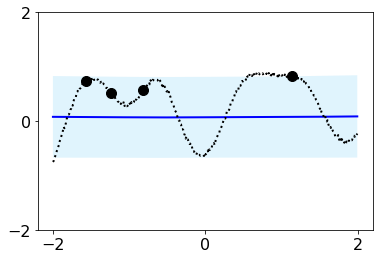

Iteration: 20000, loss: 0.5018330216407776


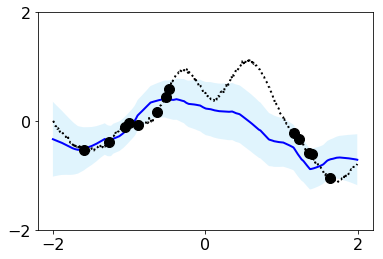

Iteration: 40000, loss: 0.7278221249580383


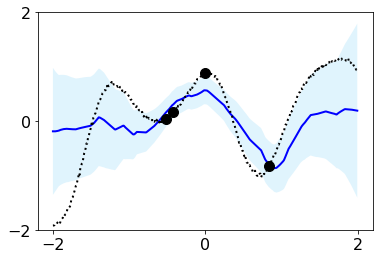

Iteration: 60000, loss: 1.2892193794250488


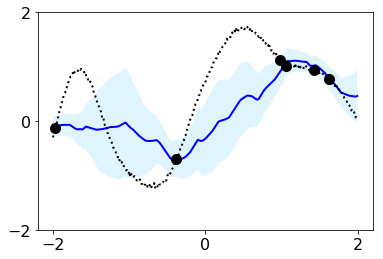

Iteration: 80000, loss: 1.1041741371154785


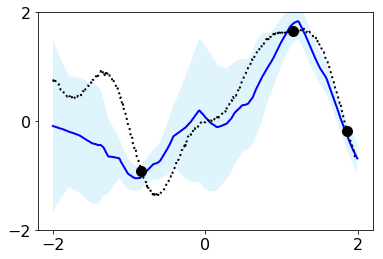

Iteration: 100000, loss: 0.13992439210414886


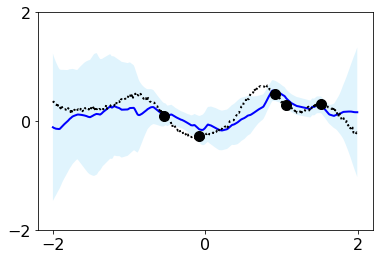

Iteration: 120000, loss: 0.21813969314098358


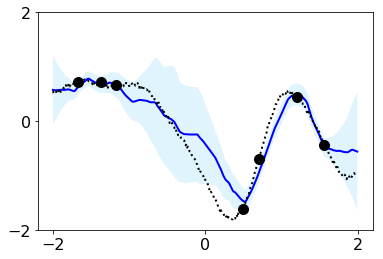

Iteration: 140000, loss: 1.198183298110962


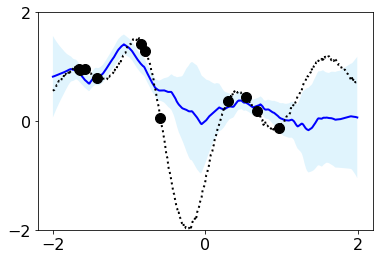

Iteration: 160000, loss: 0.9694373607635498


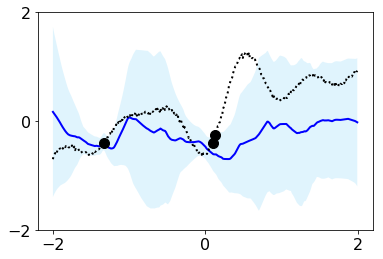

Iteration: 180000, loss: 0.7823129892349243


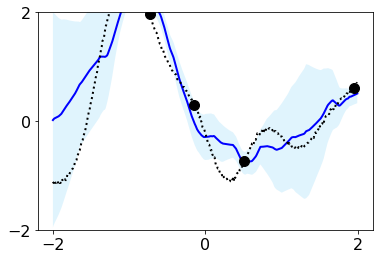

Iteration: 200000, loss: 0.9920781850814819


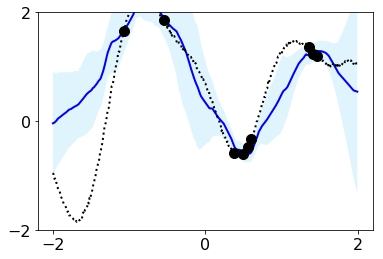

Iteration: 220000, loss: 1.1492302417755127


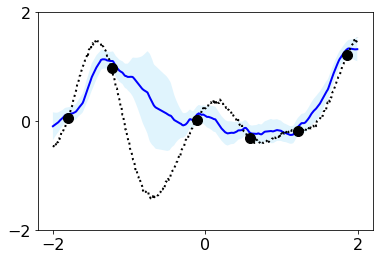

Iteration: 240000, loss: 0.7768857479095459


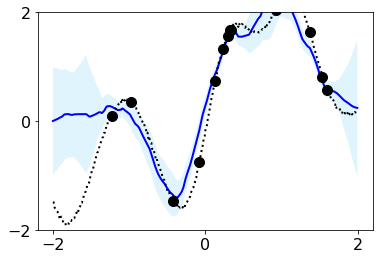

Iteration: 260000, loss: 0.2923426330089569


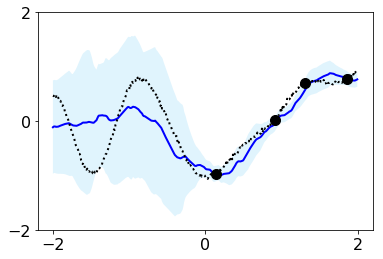

Iteration: 280000, loss: 0.26996365189552307


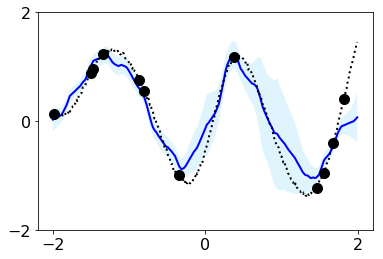

Iteration: 300000, loss: -0.13052502274513245


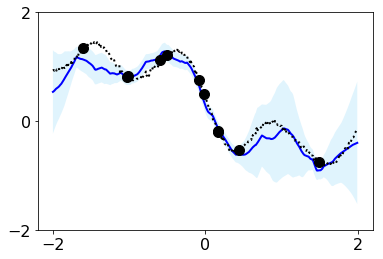

Iteration: 320000, loss: 1.140373945236206


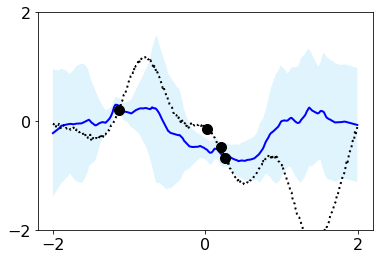

Iteration: 340000, loss: 0.2806210219860077


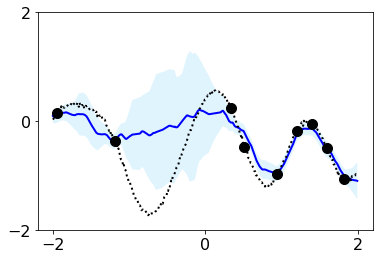

Iteration: 360000, loss: 0.5798161029815674


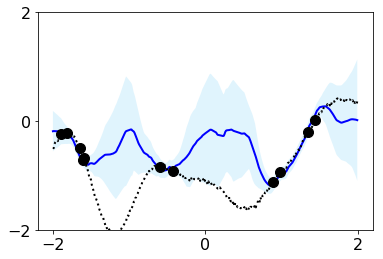

KeyboardInterrupt: 

In [18]:
for it in range(TRAINING_ITERATIONS):
    train_context_x, train_context_y, train_target_x, train_target_y = dataset_train.generate_curves()
    dist, _, _ = model(train_context_x, train_context_y, train_target_x)

    log_p = dist.log_prob(train_target_y)
    loss = -log_p.mean()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
        # Get the predicted mean and variance at the target points for the testing set
        test_context_x, test_context_y, test_target_x, test_target_y = dataset_test.generate_curves(
        )
        dist, mu, sigma = model(test_context_x, test_context_y, test_target_x)
        log_p = dist.log_prob(test_target_y)
        loss = -log_p.mean()

        print('Iteration: {}, loss: {}'.format(it, loss.detach().numpy()))

        # Plot the prediction and the context
        plot_functions(test_target_x.detach().numpy(),
                       test_target_y.detach().numpy(),
                       test_context_x.detach().numpy(),
                       test_context_y.detach().numpy(),
                       mu.detach().numpy(),
                       sigma.detach().numpy())

In [ ]:
print(model)